# 

In [ ]:
import csv
import os
import json
import ast
from pathlib import Path

dataset_dir = Path("../5. Evaluation/5.1. Dataset/")

def load_DNSreqs_uniqIPs(row):
    features = row[0]
    features = "\"" + features + "\""
    features = features.replace("Decimal('", "")
    features = features.replace("')", "")
    
    try:
        features = json.loads(features)
        features = ast.literal_eval(features)
    except:
        return -1, -1 ,-1
    
    nb_uniq_IPs_first = int(features['uniq_pkt_cntctd_all'])
            
    features = row[-1]
    features = "\"" + features + "\""
    features = features.replace("Decimal('", "")
    features = features.replace("')", "")
    try:
        features = json.loads(features)
        features = ast.literal_eval(features)
    except:
         return -1, -1 ,-1

    nb_uniq_IPs_last = int(features['uniq_pkt_cntctd_all'])
    nb_dnsreqs = len(row[2:])
    
    return nb_uniq_IPs_first, nb_uniq_IPs_last, nb_dnsreqs



# The files DNSreq_uniqIPs/data_no_infection_dns-XX_DNSreq_ft.csv contains the DNS Requests and unique IP addresses 
# contacted (similar to the typical files, but instead of NXDs, I am doing the DNS requests.
# but before, I will load all hosts that have at least 1 NXD, so that my data is focused on hosts that show at least 1 NXD 
ctu_hosts_with_1NXD = []
for i in range(42, 55): 
    ctu_fname = "data_no_infection_dns-" + str(i) + "_4.csv"
    ctu_rel_path = dataset_dir / "normal_ctu" / ctu_fname
    with open(ctu_rel_path, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if len(row) > 3: 
                ctu_hosts_with_1NXD.append(row[0] + row[1])
                
print("Done1, ", len(ctu_hosts_with_1NXD))
               
# Now, parsing DNSreq_uniqIPs/data_no_infection_dns-XX_DNSreq_ft.csv
ctu_ls = []
for i in range(42, 55): 
    ctu_fname = "data_no_infection_dns-" + str(i) + "_DNSreq_ft.csv"
    ctu_rel_path = dataset_dir / "dataset_DNSreqs" / "CTU_DNSreqs" / ctu_fname
    with open(ctu_rel_path, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            if len(row) < 3:
                continue
            if str(row[0] + row[1]) in ctu_hosts_with_1NXD:
                nb_uniq_IPs_first, nb_uniq_IPs_last, nb_dnsreqs = load_DNSreqs_uniqIPs(row[2:])
                if nb_uniq_IPs_first == -1:
                    continue
                ctu_ls.append([nb_uniq_IPs_first, nb_uniq_IPs_last, nb_dnsreqs])

print("Done2", len(ctu_ls))


# Now, parsing DNSreq_uniqIPs/data_no_infection_dns-XX_DNSreq_ft.csv
dga_ls = []
dga_dnsreq_fname = dataset_dir / "dataset_DNSreqs" / "DGA_DNSreqs" / "trans_icc_DNSreq_ft.csv"
with open(dga_dnsreq_fname, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        nb_uniq_IPs_first, nb_uniq_IPs_last, nb_dnsreqs = load_DNSreqs_uniqIPs(row[3:])
        if nb_uniq_IPs_first == -1:
            continue
        dga_ls.append([nb_uniq_IPs_first, nb_uniq_IPs_last, nb_dnsreqs])
        
print("Done3", len(dga_ls))

Done1,  990


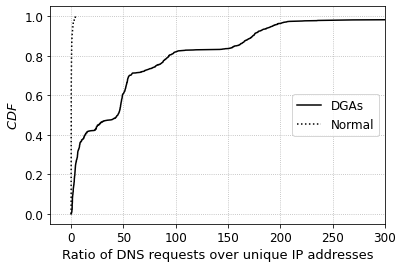

In [15]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def plot_CDF(xlabel, ls1, xlim_val=None, label1=None, ls2=None, label2=None, outputfig=None):
    fig = plt.figure(figsize=(6,4))
    matplotlib.rcParams.update({'font.size': 12})
    ax2 = fig.add_subplot()
 
    ls1_sorted = np.sort(ls1)
    ls1_p = 1. * np.arange(len(ls1)) / (len(ls1) - 1)
    ax2.plot(ls1_sorted, ls1_p, color='k', label=label1)
    # ls1_mean = ls1_sorted.mean()
    # ls1_std = ls1_sorted.std()
 
    if not ls2 == None:
        ls2_sorted = np.sort(ls2)
        ls2_p = 1. * np.arange(len(ls2)) / (len(ls2) - 1)
        ax2.plot(ls2_sorted, ls2_p, color='k', linestyle='dotted', label=label2)
        # ls2_mean = ls2_sorted.mean()
        # ls2_std = ls2_sorted.std()
 
    if not label1 == None:
 
        ax2.legend(loc='center right')
 
    ax2.set_xlabel(xlabel, fontsize=13)
    ax2.set_ylabel('$CDF$', fontsize=13)
    ax2.grid(linestyle='dotted')
    if xlim_val != None:
        plt.xlim([-20, xlim_val])
 
    if outputfig != None:
        plt.savefig(outputfig)
 
    # plt.show()

ctu_ls2 = []
dga_ls2 = []
for e in ctu_ls:
    nb_uniq_IPs_first = e[0]
    nb_uniq_IPs_last = e[1]
    nb_dnsreqs = e[2]
    
    ctu_ls2.append(nb_dnsreqs/(nb_uniq_IPs_last - nb_uniq_IPs_first + 1))
    # print(nb_dnsreqs/(nb_uniq_IPs_last - nb_uniq_IPs_first + 1))
    
# print("--------------------------------------------------------------------")   

for e in dga_ls:
    nb_uniq_IPs_first = e[0]
    nb_uniq_IPs_last = e[1]
    nb_dnsreqs = e[2]
    dga_ls2.append(nb_dnsreqs/(nb_uniq_IPs_last - nb_uniq_IPs_first + 1))
    
plot_CDF("Ratio of DNS requests over unique IP addresses", dga_ls2, xlim_val=300, label1="DGAs", ls2=ctu_ls2, label2="Normal", outputfig="DNSreq_IP_ratio.pdf")